# Notebook for [Recording gene expression order in DNA by CRISPR addition of retron barcodes (Bhattarai-Kline, S. et. al 2022, Nature)](https://www.nature.com/articles/s41586-022-04994-6)

#### MiSeq data ingestion and processing for targeted CRISPR spacer acquisition experiments.

Dependencies:
    
* fuzzysearch
* Biopython (if not, install: `pip install biopython`)
* seaborn (if not, install: `pip install seaborn`)
* numpy
* sickle (or sickle-trim -- if not, install: `conda install sickle-trim`; `conda install -c bioconda sickle-trim`)
* parallel-fastq-dump (if not, install: `pip install parallel-fastq-dump`; `conda install parallel-fastq-dump`)





### 1. Check dependencies -- install them if needed

In [5]:
import pkg_resources, sys
from pkg_resources import DistributionNotFound, VersionConflict

dependencies = [
    'biopython',
    'parallel-fastq-dump',
    'sickle-trim',
    'seaborn',
    'fuzzysearch',
    'pandas',
    'multiprocess']

for d in dependencies:
    print (d)
    try:
        pkg_resources.require(d)
    except Exception as e:
        print (e)
        print ("installing dependency: ", d)
        ! conda install --yes --prefix {sys.prefix} $d


biopython
parallel-fastq-dump
sickle-trim
The 'sickle-trim' distribution was not found and is required by the application
installing dependency:  sickle-trim
Solving environment: done

# All requested packages already installed.

seaborn
fuzzysearch
pandas
multiprocess


### 2. Import packages / dependencies

In [14]:
import sys, os, glob, re, shutil, subprocess, itertools, multiprocessing
from collections import Counter, OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fuzzysearch
from difflib import SequenceMatcher

from multiprocessing import Process, Manager
import multiprocess as mp

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord



plt.rcParams['pdf.fonttype'] = 42
pd.options.mode.chained_assignment = None  # default='warn'


### 3. Load SRA run table
This dataframe contains metadata describing the sequencing files. You can find the file `SraRunTable.txt` [here](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA838025/).

In [7]:
# load dataframe 

df_files = pd.read_excel("sequencing_files_by_figure.xlsx")[["Figure", "Panel", "Condition", "Replicate", "Exact filename"]]
df_files

,Figure,Panel,Condition,Replicate,Exact filename
0,1,e,v32+RT,1,MS48_S6.fastq
1,1,e,v32+RT,2,MS54_S13.fastq
2,1,e,v32+RT,3,MS54_S14.fastq
3,1,e,v32+RT,4,MS54_S15.fastq
4,1,e,v32-RT,1,MS54_S19.fastq
...,...,...,...,...,...
310,7,abcd,day5_PCR4,3,msSBK_30_24.fastq
311,7,abcd,day9_PCR1,3,msSBK_30_33.fastq
312,7,abcd,day9_PCR2,3,msSBK_30_34.fastq
313,7,abcd,day9_PCR3,3,msSBK_30_35.fastq


#### In this notebook, we'll focus on re-creating figure 4L

In [8]:
df_fig4 = df_files[(df_files["Figure"] == 4) & (df_files["Panel"] == "l")]
df_fig4

,Figure,Panel,Condition,Replicate,Exact filename
120,4,l,AB_PCR1,1,msSBK_15_01.fastq
121,4,l,AB_PCR2,1,msSBK_15_13.fastq
122,4,l,AB_PCR3,1,msSBK_15_25.fastq
123,4,l,AB_PCR4,1,msSBK_15_37.fastq
124,4,l,AB_PCR1,2,msSBK_15_05.fastq
125,4,l,AB_PCR2,2,msSBK_15_17.fastq
126,4,l,AB_PCR3,2,msSBK_15_29.fastq
127,4,l,AB_PCR4,2,msSBK_15_41.fastq
128,4,l,AB_PCR1,3,msSBK_15_09.fastq
129,4,l,AB_PCR2,3,msSBK_15_21.fastq


In [9]:
# for this paper: PRJNA838025

In [6]:
# # try something else -- go from sra run table 
# df_files = pd.read_csv("SraRunTable.txt")#[["Figure", "Panel", "Condition", "Replicate", "Exact filename"]]
# df_files["Figure"]

In [7]:
# df_fig4 = df_files[df_files["Figure"] == "Fig5f"]
# df_fig4

### 4. Download the FASTQs, using [`parallel-fastq-dump`](https://github.com/rvalieris/parallel-fastq-dump)

In [8]:
# for file in df_fig4["Run"].values:
#     print (file)
    
#     ##  fetch files 
    
#     #! parallel-fastq-dump --sra-id $file --threads 16 --outdir ./fastqs --split-files --gzip

#     ##  trim files
#     r1 = glob.glob("./fastqs/{0}_1.fastq".format(file))[0]
#     #print (r1)
#     #old_r1 = glob.glob("trimmed_*")[0]
#     #print ("\nremoving pre-existing trimmed files\n")
#     #os.remove(old_r1)


#     print ("\ntrimming files\n")
#     cmd = "sickle se -f ./fastqs/{0} -t sanger \
#             -o ./fastqs/{1}_trimmed.fastq".format(r1, file)
#     os.system(cmd)
#     print ("="*60)

### 5. Trim FASTQs, using [`sickle-trim`](https://github.com/najoshi/sickle)

In [9]:
for file in df_fig4["Exact filename"].values:
    #print (file)
    
    ##  fetch files 
    
    #! parallel-fastq-dump --sra-id $file --threads 16 --outdir ./fastqs --split-files --gzip
    
    ##  trim files
    #print (glob.glob("./fastqs/*.fastq"))
    #print ("./fastqs/{0}.fastq".format(file))
    try:
        r1 = glob.glob("./fastqs/{0}".format(file))[0]
        print (r1)
        #old_r1 = glob.glob("trimmed_*")[0]
        #print ("\nremoving pre-existing trimmed files\n")
        #os.remove(old_r1)
        print ("\ntrimming files\n")
        cmd = "sickle se -f {0} -t sanger \
                    -o ./fastqs/{1}_trimmed.fastq".format(r1, file.split(".fastq")[0])
        os.system(cmd)
        print ("="*60)
    except:
        print ("file not found: ", file)

./fastqs/msSBK_15_01.fastq

trimming files


FastQ records kept: 199451
FastQ records discarded: 3

./fastqs/msSBK_15_13.fastq

trimming files


FastQ records kept: 312665
FastQ records discarded: 3

./fastqs/msSBK_15_25.fastq

trimming files


FastQ records kept: 289245
FastQ records discarded: 3

./fastqs/msSBK_15_37.fastq

trimming files


FastQ records kept: 374855
FastQ records discarded: 3

./fastqs/msSBK_15_05.fastq

trimming files


FastQ records kept: 238880
FastQ records discarded: 2

./fastqs/msSBK_15_17.fastq

trimming files


FastQ records kept: 495788
FastQ records discarded: 2

./fastqs/msSBK_15_29.fastq

trimming files


FastQ records kept: 154201
FastQ records discarded: 1

./fastqs/msSBK_15_41.fastq

trimming files


FastQ records kept: 214018
FastQ records discarded: 3

./fastqs/msSBK_15_09.fastq

trimming files


FastQ records kept: 244289
FastQ records discarded: 2

./fastqs/msSBK_15_21.fastq

trimming files


FastQ records kept: 322949
FastQ records discarded: 2



### 6. Set global variables
* `Repeat`: the repeat sequence found separating the endogenous spacers of the E. coli Type I-E CRISPR system;
* `Old_SPCR1-4`: the spacers found endogenously in the  E. coli Type I-E CRISPR array.
* `dist_repeat` and `dist_oldSPCRs` set "fuzziness", or how flexible the functions run below will be to mismatches between the target and query sequences (Repeats + Spacers, and sequences extracted from the parsed reads, respectively).

In [10]:
# These are the sequences found in the CRISPR array.
Repeat = 'GTGTTCCCCGCGCCAGCGGGGATAAACC'
Old_SPCR1 = 'GAGCACAAATATCATCGCTCAAACCACTTACGG'
Old_SPCR2 = 'GCCTCGCTGTAAATTCCAAAAACGATCTCTATA'
Old_SPCR3 = 'GACAGTACCGGAGTTTGACGGTGCCAACGGCGG'
Old_SPCR4 = 'GACAATCAGGGAACGATTGTTGACACTGTAAAA'

# Sets the overall fuzziness
dist_repeat = 4
dist_oldSPCRs = 5
dict_data = {}

### 7. Define functions that will be used throughout the notebook

In [61]:

def get_spcrs(sequence):
    last_rep = fuzzysearch.find_near_matches(Repeat[0:15], sequence, max_l_dist=3)
    results = fuzzysearch.find_near_matches(Repeat, sequence, max_l_dist=6)
    
    if ((len(results) == 3) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        spacer_list.append(sequence[results[2].end:last_rep[len(last_rep)-1].start])
        
    elif ((len(results) == 2) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:last_rep[len(last_rep)-1].start])
        
    elif ((len(results) == 1) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:last_rep[len(last_rep)-1].start]]

    elif len(results) == 4:
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        spacer_list.append(sequence[results[2].end:results[3].start])
        
    elif len(results) == 3:
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        
    elif len(results) == 2:
        spacer_list = [sequence[results[0].end:results[1].start]]
    else:
        spacer_list = []
        
    return spacer_list

def not_existing(spacer):
    if SequenceMatcher(None,Old_SPCR1,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR2,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR3,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR4,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Repeat,spacer).ratio() < 0.83:
        return True
    else: return False

### functions for oComp_Order

def get_spcrs_11BC(sequence):
    last_rep = fuzzysearch.find_near_matches(Repeat[0:15], sequence, max_l_dist=3)
    results = fuzzysearch.find_near_matches(Repeat, sequence, max_l_dist=6)
    if ((len(results) == 3) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])
        spacer_list.append(sequence[results[2].end+5:last_rep[len(last_rep)-1].start-5])
        
    elif ((len(results) == 2) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:last_rep[len(last_rep)-1].start-5])
        
    elif ((len(results) == 1) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:last_rep[len(last_rep)-1].start-5]]
    
    elif len(results) == 4:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])
        spacer_list.append(sequence[results[2].end+5:results[3].start-5])

    elif len(results) == 3:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])

    elif len(results) == 2:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]

    else:
        spacer_list = []
        
    return spacer_list

def matchesTarget(target,seq):
    if bool(fuzzysearch.find_near_matches(Target_dict[target], seq, max_l_dist=mismatch_tol)):
        return True
    else:
        return False
    
def double_order(double):
    
    """input is two spacers from a double expansion
    returns tuple of coded spacers, e.g. ('A','B') or ('B','N')"""
    
    First = 'N'
    Second = 'N'
    for target in ['A','B']:

        if matchesTarget(target,double[0]):
            First = target
        if matchesTarget(target,double[1]):
            Second = target
    order = (First,Second)
    return order

def triple_order(triplet):
    """input is three spacers from a triple expansion
    returns tuple of coded spacers"""
    First = 'N'
    Second = 'N'
    Third = 'N'
    for target in ['A','B']:
        if matchesTarget(target,triplet[0]):
            First = target
        if matchesTarget(target,triplet[1]):
            Second = target
        if matchesTarget(target,triplet[2]):
            Third = target
    order = (First,Second,Third)
    return order


def multiprocess_spr(file):

    sampleID = os.path.splitext(file)[0] 
    
    ddd = \
    {
        "wildtype_sequences_three_read": [], 
        "wildtype_sequences_two_read": [],
        "wildtype_sequences_one_read": [], 
        "single_expansion_sequences_three_read_pos_one": [],
        "single_expansion_sequences_three_read_pos_two": [],
        "single_expansion_sequences_two_read_pos_one": [],
        "single_expansion_sequences_two_read_pos_two": [],
        "single_expansion_sequences_one_read": [],
        "single_replacement_sequences_two_read_pos_one": [],
        "double_expansion_sequences_two_read": [],
        "double_expansion_sequences_three_read": [],
        "triple_expansion_sequences_three_read": [],
        "SPCR1_deletion_sequences_two_read": [],
        "SPCR1_deletion_sequences_one_read": [],
        "weird_sequences_three_read": [],
        "weird_sequences_two_read": [],
        "weird_sequences_one_read": [],
        "weird_sequences_none_read": [],
        "new_SPCRs": [],
        "new_SPCRs_just_seqs": [],
        "unique_new_SPCRs": [],
        "Unaligned_SPCRs": [],
        "new_SPCR_lengths": [],
        "number_nonweird_reads": [],
        "nonfed_lengths": [],
        "fed_lengths": [],
        "total_reads": [],
    }
    

    fastq_reads = file
    print (fastq_reads)
    

    read_counter = Counter([str(i.seq) for i in SeqIO.parse(fastq_reads, "fastq")])
    
    ddd["total_reads"] = sum(read_counter.values())
    for read in read_counter:
        spacer_list = get_spcrs(read)
        
        #reads that have three clean spacers
        if len(spacer_list) == 3:
            
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                if SequenceMatcher(None,Old_SPCR2,spacer_list[1]).ratio() > 0.83:
                    if SequenceMatcher(None,Old_SPCR3,spacer_list[2]).ratio() > 0.83:
                        ddd["wildtype_sequences_three_read"].extend([read]*read_counter[read])

    
            elif not_existing(spacer_list[0]) == True:
                if not_existing(spacer_list[1]) == True:
                    if not_existing(spacer_list[2]) == True:
                        ddd["triple_expansion_sequences_three_read"].extend([read]*read_counter[read])

                        if len(spacer_list[0]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        if len(spacer_list[1]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                        if len(spacer_list[2]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[2]]*read_counter[read])
                    else:
                        ddd["double_expansion_sequences_three_read"].extend([read]*read_counter[read])
                        if len(spacer_list[0]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        if len(spacer_list[1]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                else:
                    ddd["single_expansion_sequences_three_read_pos_one"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                
            elif ((not_existing(spacer_list[0]) == False) and (not_existing(spacer_list[1]) == True)):
                ddd["single_expansion_sequences_three_read_pos_two"].extend([read]*read_counter[read])
                #not taking spacers from this
            else:
                ddd["weird_sequences_three_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 2:
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                if SequenceMatcher(None,Old_SPCR2,spacer_list[1]).ratio() > 0.83:
                    ddd["wildtype_sequences_two_read"].extend([read]*read_counter[read])
            elif not_existing(spacer_list[0]) == True:
                if not_existing(spacer_list[1]) == True:
                    ddd["double_expansion_sequences_two_read"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                    if len(spacer_list[1]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                else:
                    ddd["single_expansion_sequences_two_read_pos_one"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        
            elif ((not_existing(spacer_list[0]) == False) and (not_existing(spacer_list[1]) == True)):
                ddd["single_expansion_sequences_two_read_pos_two"].extend([read]*read_counter[read])
            else:
                ddd["weird_sequences_two_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 1:
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                ddd["wildtype_sequences_one_read"].extend([read]*read_counter[read])
            elif not_existing(spacer_list[0]) == True:
                ddd["single_expansion_sequences_one_read"].extend([read]*read_counter[read])
                if len(spacer_list[0]) < 61:
                    ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
            else:
                ddd["weird_sequences_one_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 0:
            ddd["weird_sequences_none_read"].extend([read]*read_counter[read])
    print (len(ddd["new_SPCRs"]), "new spacers found")
    print (ddd["total_reads"], "total reads in FASTQ")
    tbr = {file: ddd}

    return tbr

### tk. For each read in each FASTQ, extract new spacers and store them according to their characteristics and the characteristics of the CRISPR arrays from which they were extracted
The idea of this cell is to execute the function defined above as `multiprocess_spr`. This function will:
* setup a temporary dictionary, `ddd`, to store the new spacer data;
* generate a counter of the reads in the input FASTQ, for the sake of expediting the analysis;
* iterate through each read in the counter, extract and and determine the characteristics of the read and its spacer(s), such as:
    * does the read contain one or more spacers;
    * are the spacers **"old"** (one of the spacers found in the endogenous CRISPR array) or **"new"**;
* store the read and spacer information in the temp dictionary `ddd` as a dictionary ~ `{"FASTQ_n": ddd}`, where `ddd` is the dictionary with the information collected on all of the FASTQ's reads;
* return the dictionary for downstream analysis.    
     
Note that the function called to extract the spacers is `get_spcrs`, which takes as input a read, and outputs a list of spacers. This list of spacers is then processed by the rest of the `multiprocess_spr` function and the features detailed above are extracted and used to bin the spacers and reads, which are finally added to the temporary dictionary `ddd` as discussed above.    

This cell does most of the heavy lifting and takes a while to run because of the number of reads per FASTQ.      
To speed things up, we use multiprocessing to offload tasks to worker processes, and enables the analysis of multiple FASTQs in parallel.      
The number of processes run will be `cpu_count - 1`, where `cpu_count` is the number of CPUs in the system (i.e., on your laptop or cluster).

In [17]:
in_lst = glob.glob("./fastqs/*_trimmed.fastq")

with mp.Pool(multiprocessing.cpu_count()-1) as pool:
    #print ("here")
    rezie = pool.map(multiprocess_spr, in_lst)
    #print ("done I think")

./fastqs/msSBK_17_09_trimmed.fastq./fastqs/msSBK_18_169_trimmed.fastq./fastqs/msSBK_17_33_trimmed.fastq./fastqs/msSBK_17_37_trimmed.fastq./fastqs/msSBK_17_34_trimmed.fastq./fastqs/msSBK_15_01_trimmed.fastq./fastqs/msSBK_18_174_trimmed.fastq./fastqs/msSBK_15_22_trimmed.fastq./fastqs/msSBK_17_29_trimmed.fastq./fastqs/msSBK_15_41_trimmed.fastq./fastqs/msSBK_17_17_trimmed.fastq










2460 new spacers found
55270 total reads in FASTQ
./fastqs/msSBK_17_30_trimmed.fastq
3080 new spacers found
74736 total reads in FASTQ
./fastqs/msSBK_15_18_trimmed.fastq
3743 new spacers found
76369 total reads in FASTQ
./fastqs/msSBK_15_06_trimmed.fastq
2830 new spacers found
81027 total reads in FASTQ
./fastqs/msSBK_15_26_trimmed.fastq
3231 new spacers found
87117 total reads in FASTQ
./fastqs/msSBK_15_05_trimmed.fastq
3679 new spacers found
89390 total reads in FASTQ
./fastqs/msSBK_15_02_trimmed.fastq
1000 new spacers found
54931 total reads in FASTQ
./fastqs/msSBK_15_21_trimmed.fastq
13738 new spacers 

### Build a new dictionary, `dict_data`, with data for all FASTQs processed.
`dict_data` is structured as follows:

```
dict_data = {
    ./fastqs/FASTQ_1_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
    ./fastqs/FASTQ_2_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
    ...
    ./fastqs/FASTQ_n_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
            }
```
For all the data stored in the dictionary, refer to the function `multiprocess_spr` defined above.


In [19]:
#print (rezie[0].keys())
for i in rezie:
    dict_data.update(i)
print(dict_data.keys())

dict_keys(['./fastqs/msSBK_15_01_trimmed.fastq', './fastqs/msSBK_15_38_trimmed.fastq', './fastqs/msSBK_17_37_trimmed.fastq', './fastqs/msSBK_15_05_trimmed.fastq', './fastqs/msSBK_17_33_trimmed.fastq', './fastqs/msSBK_15_02_trimmed.fastq', './fastqs/msSBK_17_34_trimmed.fastq', './fastqs/msSBK_15_06_trimmed.fastq', './fastqs/msSBK_17_09_trimmed.fastq', './fastqs/msSBK_17_30_trimmed.fastq', './fastqs/msSBK_18_169_trimmed.fastq', './fastqs/msSBK_15_45_trimmed.fastq', './fastqs/msSBK_18_174_trimmed.fastq', './fastqs/msSBK_18_170_trimmed.fastq', './fastqs/msSBK_15_41_trimmed.fastq', './fastqs/msSBK_17_14_trimmed.fastq', './fastqs/msSBK_15_22_trimmed.fastq', './fastqs/msSBK_17_10_trimmed.fastq', './fastqs/msSBK_17_29_trimmed.fastq', './fastqs/msSBK_15_26_trimmed.fastq', './fastqs/msSBK_17_17_trimmed.fastq', './fastqs/msSBK_15_18_trimmed.fastq', './fastqs/msSBK_15_21_trimmed.fastq', './fastqs/msSBK_17_13_trimmed.fastq', './fastqs/msSBK_15_25_trimmed.fastq', './fastqs/msSBK_15_46_trimmed.fastq'

The dictionary `dict_data` contains lots of useful information. For instance, one can look up the total number of reads for any given FASTQ, as shown below:

In [56]:
print (dict_data["./fastqs/msSBK_15_01_trimmed.fastq"]["total_reads"])

199451


### Determine the order of spacers in each sequenced CRISPR array
To do this, we've defined that a retron-derived spacer is spacer that contains an 11-base region of the hypothetical prespacer, consisting of the 7-base barcode region, and 2 bases on either side (with one mismatch or indel allowed).   
For instance, an `A` retron-derived spacer would have an 11bp core region consisting of the following sequence: `GTTGCAGCAAC`.       
Similarly, a `B` retron-derived spacer would have an 11bp core region consisting of the following sequence: `GTCAGACTGAC`.     
Both of those are specified in the `Target_dict`, which is used to determine whether a spacer is an `A`, a `B`, or an `N` spacer -- the latter is any new spacer that is not classified as an `A` or a `B` spacer.    
The code below iterates through every FASTQ, generating a dictionary of the counts of every possible permutation of `ABN` spacers, both for double expansions and triple expansions. For instance, in the case of double expansions, the possibilities are:    
* `A, A`
* `A, B`
* `A, N`
* `B, B`
* `B, A`
* `B, N`
* `N, N`
* `N, A`
* `N, B`        

These counts are stored in the dictionaries `double_dict` and `triple_dict`.   

*Note that the function called is `get_spcrs_11BC`, because it involves a more 'relaxed' search for retron-derived spacers, as mentioned above*.

In [60]:
## "lenient analysis" code -- refer to https://github.com/Shipman-Lab/Spacer-Seq/blob/master/oComp_Ordering_11baseBC.py

# params
mismatch_tol = 1

double_options = [prod for prod in itertools.product('ABN', repeat=2)]
triple_options = [prod for prod in itertools.product('ABN', repeat=3)]

# sequence of spacers `A` and `B`. Change as needed.
Target_dict = {
    'A': "GTTGCAGCAAC",
    'B': "GTCAGACTGAC"
                }

count_dict = {}
percent_dict = {}
total_spcrs = {}

double_list = {}
triple_list = {}

double_dict = {}
triple_dict = {}

double_counts = {}
A_spacers = {}
B_spacers = {}

for file in glob.glob("./fastqs/*_trimmed.fastq"):
    sampleID = os.path.splitext(file)[0]

    fastq_reads = file
    print (fastq_reads)
    
    
    # init counters, dicts, lists, etc.
    count_dict[file] = {'A': 0, 'B': 0, 'N': 0}
    percent_dict[file] = {}
    total_spcrs[file] = 0

    double_dict[file] = {}
    triple_dict[file] = {}
      
    for double in double_options:
        double_dict[file][double] = 0
        
    for triple in triple_options:
        triple_dict[file][triple] = 0
    

    #Pull out spacer pairs and triplets
    
    double_list[file] = [get_spcrs_11BC(i) for i in dict_data[file]["double_expansion_sequences_two_read"]] + \
                        [get_spcrs_11BC(i) for i in dict_data[file]["double_expansion_sequences_three_read"]]
       
    triple_list[file] = [get_spcrs_11BC(i) for i in dict_data[file]["triple_expansion_sequences_three_read"]]
    
    #get order for doubles and triplets
    
    for double in double_list[file]:
        double_dict[file][double_order(double)] += 1
        
    for triplet in triple_list[file]:
        triple_dict[file][triple_order(triplet)] += 1

    # get spacer counts for each target
    
    double_counts[file] = []
    A_spacers[file] = []
    B_spacers[file] = []
    
    for seq_record in dict_data[file]["new_SPCRs"]:
        # print (seq_record)
        total_spcrs[file] +=1
        identity = []
        
        for target in Target_dict:
            if matchesTarget(target, seq_record):
                identity.append(target)
        #print (identity)
        
        if identity == []:
            identity.append('N')
    
        if identity == ['A']:
            A_spacers[file].append(seq_record)
    
        if identity == ['B']:
            B_spacers[file].append(seq_record)
    
        if len(identity) > 1:
            double_counts[file].append(seq_record)
    
        if len(identity) == 1:
            count_dict[file][identity[0]] += 1
    
    triple_dict[file]["total_reads"] = dict_data[file]["total_reads"]
    
    print('#A spacers = ',len(A_spacers[file]))
    print('#B Spacers = ',len(B_spacers[file]))
    print ()

./fastqs/msSBK_15_01_trimmed.fastq
#A spacers =  557
#B Spacers =  478

./fastqs/msSBK_15_38_trimmed.fastq
#A spacers =  38
#B Spacers =  8

./fastqs/msSBK_17_37_trimmed.fastq
#A spacers =  96
#B Spacers =  132

./fastqs/msSBK_15_05_trimmed.fastq
#A spacers =  317
#B Spacers =  363

./fastqs/msSBK_17_33_trimmed.fastq
#A spacers =  93
#B Spacers =  120

./fastqs/msSBK_15_02_trimmed.fastq
#A spacers =  4
#B Spacers =  7

./fastqs/msSBK_17_34_trimmed.fastq
#A spacers =  82
#B Spacers =  135

./fastqs/msSBK_15_06_trimmed.fastq
#A spacers =  350
#B Spacers =  561

./fastqs/msSBK_17_09_trimmed.fastq
#A spacers =  57
#B Spacers =  79

./fastqs/msSBK_17_30_trimmed.fastq
#A spacers =  24
#B Spacers =  38

./fastqs/msSBK_18_169_trimmed.fastq
#A spacers =  303
#B Spacers =  300

./fastqs/msSBK_15_45_trimmed.fastq
#A spacers =  456
#B Spacers =  603

./fastqs/msSBK_18_174_trimmed.fastq
#A spacers =  223
#B Spacers =  386

./fastqs/msSBK_18_170_trimmed.fastq
#A spacers =  179
#B Spacers =  386

./f

### tk. Generate a dataframe with the data collected above
The cell below generates a dataframe, `ordering_df`, generated by merging the dictionaries of double and triple spacer expansion ordering counts.   
Then, a second dataframe `big_df`, is generated, that merges the `ordering_df` with the metadata dataframe, described above.   
For the sake of calculating the ordering scores below, we've also added 2 columns to this new dataframe. These are the `Order`, or what the experimental order of signals were ($A \to B$ or $B \to A$); and PCR, which will allow us to average scores within biological replicates.

In [63]:
# make a dataframe with the data

ordering_df_1 = pd.DataFrame.from_dict(double_dict, orient = "index", columns = double_options).reset_index().rename(columns = {"index": "file"})
ordering_df_2 = pd.DataFrame.from_dict(triple_dict, orient = "index").reset_index().rename(columns = {"index": "file"})
ordering_df = pd.merge(left = ordering_df_1, right= ordering_df_2)



ordering_df["Exact filename"] = ordering_df["file"].str.split(r'/fastqs/(.*?)_trimmed.fastq',expand=True)[1]+".fastq"
big_df = pd.merge(left = ordering_df, right = df_fig4, on="Exact filename").drop("file", axis=1)
big_df["Order"]=big_df["Condition"].str.split("_", expand=True)[0]
big_df["PCR"] = big_df["Condition"].str.split("PCR", expand=True)[1]

This is what `big_df` looks like:

In [64]:
display(big_df)

,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)","(A, A, A)",...,"(N, N, B)","(N, N, N)",total_reads,Exact filename,Figure,Panel,Condition,Replicate,Order,PCR
0,0,0,4,1,0,7,9,5,258,0,...,0,4,199451,msSBK_15_01.fastq,4,l,AB_PCR1,1,AB,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,472730,msSBK_15_38.fastq,4,l,BA_PCR4,1,BA,4
2,0,0,0,0,0,3,6,2,75,0,...,0,1,87117,msSBK_17_37.fastq,4,l,AB_PCR4,4,AB,4
3,0,0,4,0,0,8,4,7,283,0,...,0,2,238880,msSBK_15_05.fastq,4,l,AB_PCR1,2,AB,1
4,0,0,2,0,1,4,2,1,92,0,...,0,2,89390,msSBK_17_33.fastq,4,l,AB_PCR3,6,AB,3
5,0,0,0,0,0,0,0,0,4,0,...,0,0,196237,msSBK_15_02.fastq,4,l,BA_PCR1,1,BA,1
6,0,0,0,0,0,2,0,5,102,0,...,0,1,76369,msSBK_17_34.fastq,4,l,BA_PCR3,6,BA,3
7,0,1,8,1,0,17,2,5,254,0,...,0,1,239869,msSBK_15_06.fastq,4,l,BA_PCR1,2,BA,1
8,0,0,0,0,0,0,1,0,61,0,...,0,1,55270,msSBK_17_09.fastq,4,l,AB_PCR1,6,AB,1
9,0,0,0,0,0,0,0,0,12,0,...,0,1,54931,msSBK_17_30.fastq,4,l,BA_PCR3,5,BA,3


And these are its columns:

In [65]:
big_df.columns

Index([      ('A', 'A'),       ('A', 'B'),       ('A', 'N'),       ('B', 'A'),
             ('B', 'B'),       ('B', 'N'),       ('N', 'A'),       ('N', 'B'),
             ('N', 'N'),  ('A', 'A', 'A'),  ('A', 'A', 'B'),  ('A', 'A', 'N'),
        ('A', 'B', 'A'),  ('A', 'B', 'B'),  ('A', 'B', 'N'),  ('A', 'N', 'A'),
        ('A', 'N', 'B'),  ('A', 'N', 'N'),  ('B', 'A', 'A'),  ('B', 'A', 'B'),
        ('B', 'A', 'N'),  ('B', 'B', 'A'),  ('B', 'B', 'B'),  ('B', 'B', 'N'),
        ('B', 'N', 'A'),  ('B', 'N', 'B'),  ('B', 'N', 'N'),  ('N', 'A', 'A'),
        ('N', 'A', 'B'),  ('N', 'A', 'N'),  ('N', 'B', 'A'),  ('N', 'B', 'B'),
        ('N', 'B', 'N'),  ('N', 'N', 'A'),  ('N', 'N', 'B'),  ('N', 'N', 'N'),
          'total_reads', 'Exact filename',         'Figure',          'Panel',
            'Condition',      'Replicate',          'Order',            'PCR'],
      dtype='object')

### tk. Calculate the "Ordering Scores"
As discussed in the main manuscript, we defined logical rules that should govern the ordering of spacers in the CRISPR arrays, with the hopes of infering the order of transcription of tagged genes (in this case, of distinct ncRNAs). 


Because spacers are acquired unidirectionally (see panel A of the figure below), with newer spacers closer to the leader sequence, we propose that, if transcript $A$ is expressed before transcript $B$, $A \to B \to \text{Leader}$ arrays should be more numerous than $B \to A \to \text{Leader}$ arrays. Conversely, if $B$ is expressed before $A$, the number of $B \to A \to \text{Leader}$ arrays should be greater than the number of $A \to B \to \text{Leader}$ arrays.


![Directional acquisition of new spacers](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41586-022-04994-6/MediaObjects/41586_2022_4994_Fig1_HTML.png?as=webp)

Another useful feature of using CRISPR arrays for recording is that, as hinted above, the Cas1–Cas2 complex acquires spacers derived from the plasmid and genome, which we call $N$ spacers. These untargeted acquisitions can also be used to interpret temporal information.      
    
Assuming that $N$ spacers are acquired at a constant rate, we can propose a set of rules that govern the order of $N \to A \to \text{Leader}$, $N \to B \to \text{Leader}$, $A \to N \to \text{Leader}$ and $B \to N \to \text{Leader}$ arrays, similarly to that described above.     


Explicitly, if during the experiment, spacer $A$ is available before spacer $B$, $A \to N \to \text{Leader}$ arrays should be observed more frequently than $N \to A \to \text{Leader}$ arrays. Conversely, $N \to B \to \text{Leader}$ arrays should outnumber $B \to N \to \text{Leader}$ arrays. This is because, on average and across the duration of the experiment, $B$ spacers will have been acquired more recently than $A$ spacers, and should tend to be found, on average, closer to the $\text{Leader}$.
    
In the opposite scenario, where spacer $B$ is expressed before spacer $A$, $N \to A \to \text{Leader}$ arrays should outnumber $A \to N \to \text{Leader}$ arrays, and $B \to N \to \text{Leader}$ arrays should likewise outnumber $N \to B \to \text{Leader}$ arrays.    
  
These rules can be states mathematically. We've defined the Ordering Score as the difference between possible array types (e.g., $[A \to B \to \text{Leader}] - [B \to A \to \text{Leader}]$ as the numberator and the sum of the two possibilities ($[A \to B \to \text{Leader}] + [B \to A \to \text{Leader}]$) as the denominator. This yields a score, $S \in [-1, 1]$, for each ordering rule ($A/B, A/N, B/N$). By definition, a positive value indicates that spacer $A$ was present before $B$ (i.e., the event recorded by $A$ happened before the event recorded by $B$); conversely, a negative value indicates that the $B$ spacers were present before the $A$ spacers. The magnitude of the score serves as a indicator of how well the the two signals, $A$ and $B$, are separated in time.    
    
Thus:    

$$S_{A/N} = \frac{\mathrm{f}_{A \to N \to \text{Leader}} - \mathrm{f}_{N \to A \to \text{Leader}}}{\mathrm{f}_{A \to N \to \text{Leader}} + \mathrm{f}_{N \to A \to \text{Leader}}}$$;     

$$S_{B/N} = \frac{\mathrm{f}_{N \to B \to \text{Leader}} - \mathrm{f}_{B \to N \to \text{Leader}}}{\mathrm{f}_{N \to B \to \text{Leader}} + \mathrm{f}_{B \to N \to \text{Leader}}}$$;  

$$S_{A/B} = \frac{\mathrm{f}_{B \to A \to \text{Leader}} - \mathrm{f}_{A \to B \to \text{Leader}}}{\mathrm{f}_{B \to A \to \text{Leader}} + \mathrm{f}_{A \to B \to \text{Leader}}}$$ 
     
In other words:    

$$S_{i/j} = \frac{\mathrm{f}_{j \to i \to \text{Leader}} - \mathrm{f}_{i \to j \to \text{Leader}}}{\mathrm{f}_{i \to j \to \text{Leader}} + \mathrm{f}_{j \to i \to \text{Leader}}}$$,      

Where $S_{i/j}$ is the ordering score associated with assuming an event linked to spacer $i$ happened before an event linked to spacer $j$,     
and $\mathrm{f}_{i \to j \to \text{Leader}}$ if the frequency of arrays that have the spacers ordered as $i \to j \to \text{Leader}$.

The following cell computes the score:

In [66]:
big_df["A/N"] = (big_df[('N', 'A')]-big_df[('A', 'N')])/(big_df[('A', 'N')]+big_df[('N', 'A')])
big_df["B/N"] = (big_df[('B', 'N')]-big_df[('N', 'B')])/(big_df[('B', 'N')]+big_df[('N', 'B')])
big_df["A/B"] = (big_df[('B', 'A')]-big_df[('A', 'B')])/(big_df[('A', 'B')]+big_df[('B', 'A')])

The following cell displays the `big_df` dataframe and saves it as `"full_data_ordering.csv"`.

In [67]:
display(big_df)
big_df.to_csv("full_data_ordering.csv")

,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)","(A, A, A)",...,Exact filename,Figure,Panel,Condition,Replicate,Order,PCR,A/N,B/N,A/B
0,0,0,4,1,0,7,9,5,258,0,...,msSBK_15_01.fastq,4,l,AB_PCR1,1,AB,1,0.384615,0.166667,1.0
1,0,0,0,0,0,0,0,0,1,0,...,msSBK_15_38.fastq,4,l,BA_PCR4,1,BA,4,NaN,NaN,NaN
2,0,0,0,0,0,3,6,2,75,0,...,msSBK_17_37.fastq,4,l,AB_PCR4,4,AB,4,1.000000,0.200000,NaN
3,0,0,4,0,0,8,4,7,283,0,...,msSBK_15_05.fastq,4,l,AB_PCR1,2,AB,1,0.000000,0.066667,NaN
4,0,0,2,0,1,4,2,1,92,0,...,msSBK_17_33.fastq,4,l,AB_PCR3,6,AB,3,0.000000,0.600000,NaN
5,0,0,0,0,0,0,0,0,4,0,...,msSBK_15_02.fastq,4,l,BA_PCR1,1,BA,1,NaN,NaN,NaN
6,0,0,0,0,0,2,0,5,102,0,...,msSBK_17_34.fastq,4,l,BA_PCR3,6,BA,3,NaN,-0.428571,NaN
7,0,1,8,1,0,17,2,5,254,0,...,msSBK_15_06.fastq,4,l,BA_PCR1,2,BA,1,-0.600000,0.545455,0.0
8,0,0,0,0,0,0,1,0,61,0,...,msSBK_17_09.fastq,4,l,AB_PCR1,6,AB,1,1.000000,NaN,NaN
9,0,0,0,0,0,0,0,0,12,0,...,msSBK_17_30.fastq,4,l,BA_PCR3,5,BA,3,NaN,NaN,NaN


To make the data plottable, we generate a smaller dataframe, `summarized_df`, that contains information about the filename, the order, the biological replicate, the PCR, the score and what kind of score it is. The dataframe is also saved as `"summarized_data_ordering.csv"`.

In [68]:
df_AN = pd.concat([big_df[['Exact filename', 'Order', "Replicate", "PCR", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(big_df.index), columns=['Type'])], axis=1)
df_BN = pd.concat([big_df[['Exact filename','Order', "Replicate", "PCR", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(big_df.index), columns=['Type'])], axis=1)
df_AB = pd.concat([big_df[['Exact filename','Order', "Replicate", "PCR", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(big_df.index), columns=['Type'])], axis=1)
summarized_df = pd.concat([df_AN, df_BN, df_AB])
summarized_df.to_csv("summarized_data_ordering.csv")
display(summarized_df)


,Exact filename,Order,Replicate,PCR,Score,Type
0,msSBK_15_01.fastq,AB,1,1,0.384615,A/N
1,msSBK_15_38.fastq,BA,1,4,NaN,A/N
2,msSBK_17_37.fastq,AB,4,4,1.000000,A/N
3,msSBK_15_05.fastq,AB,2,1,0.000000,A/N
4,msSBK_17_33.fastq,AB,6,3,0.000000,A/N
...,...,...,...,...,...,...
49,msSBK_17_25.fastq,AB,4,3,NaN,A/B
50,msSBK_15_13.fastq,AB,1,2,NaN,A/B
51,msSBK_17_21.fastq,AB,6,2,NaN,A/B
52,msSBK_15_17.fastq,AB,2,2,NaN,A/B


Lastly, before plotting the data, we generated a final dataframe, `plt_df`, which contains a subset of the information of `summarized_df`, and calculates the average score per biological replicate, while keeping the information about what the order of the experiment was.

In [71]:
plt_df = summarized_df.groupby(["Type", "Replicate", "Order"]).mean().reset_index(level=["Type"]).reset_index()
plt_df.to_csv("plotting_data_ordering.csv")
display(plt_df)

,Replicate,Order,Type,Score
0,1,AB,A/B,1.000000
1,1,BA,A/B,NaN
2,2,AB,A/B,NaN
3,2,BA,A/B,0.000000
4,3,AB,A/B,1.000000
5,3,BA,A/B,-1.000000
6,4,AB,A/B,NaN
7,4,BA,A/B,NaN
8,5,AB,A/B,NaN
9,5,BA,A/B,NaN


This cell generates two overlaid plots:
* A swarmplot, showing the mean value of each score per biological replicate;
* A violinplot, to give a sense of the distribution of the scores.
   
Additionally, we've added a horizontal line at $0$, for the purpose of separating scores corresponding to "$A$ happened before $B$" (positive ordering score values) from scores corresponding to "$B$ happened before $A$" (negative ordering score values).

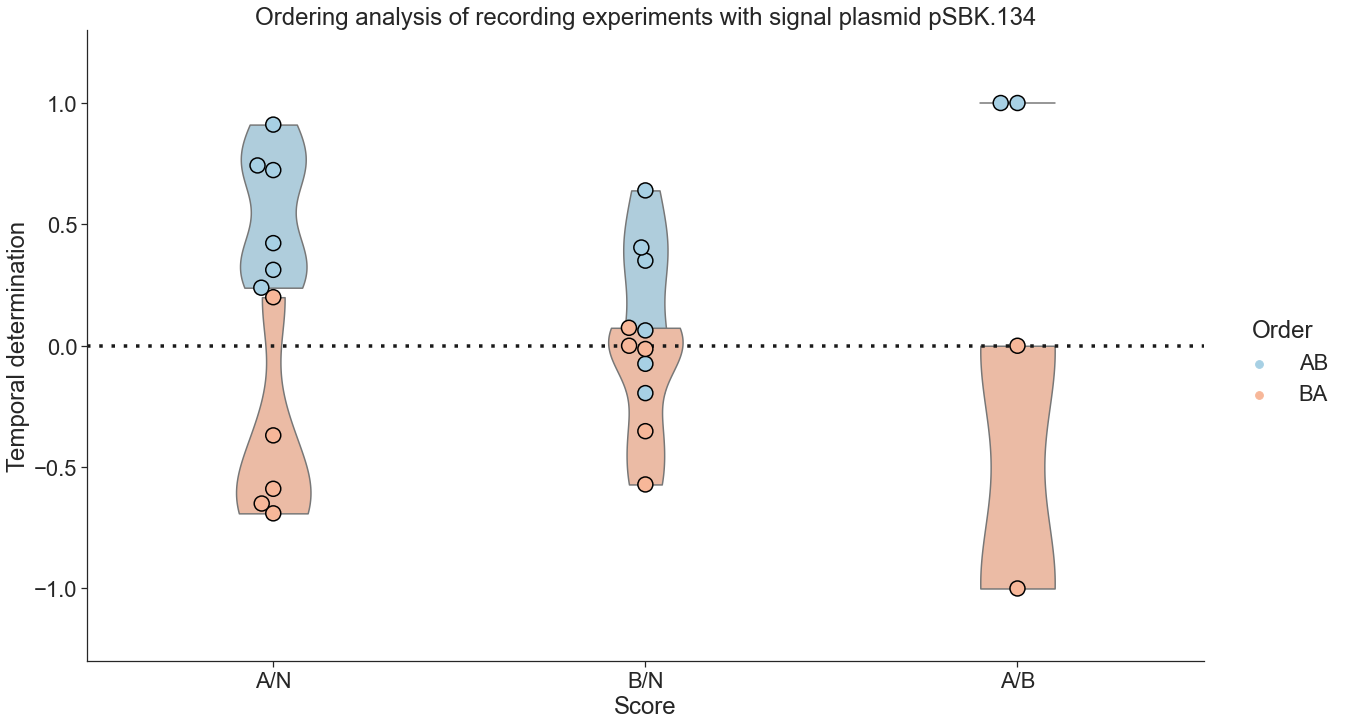

In [72]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=plt_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=plt_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title="Ordering analysis of recording experiments with signal plasmid pSBK.134")

g.savefig("ordering_analysis_134.pdf")

In [ ]:
### everything below this needs a lot of work

In [ ]:
# """Run"""
# #Create Results folder
# newpath = ((r'%s/%s_Results') % (Data_Path,sampleID))
# if not os.path.exists(newpath): os.makedirs(newpath)

# #Dump the data back into fastq files
# if write_binned_whole_reads_to_fastq == 'yes':
#     wildtype_sequences_three_read_q = open("%s/%s_Results/wildtype_sequences_"
#     "three_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(wildtype_sequences_three_read, wildtype_sequences_three_read_q,
#     "fastq")
#     wildtype_sequences_three_read_q.close()

#     wildtype_sequences_two_read_q = open("%s/%s_Results/wildtype_sequences_"
#     "two_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(wildtype_sequences_two_read, wildtype_sequences_two_read_q,
#     "fastq")
#     wildtype_sequences_two_read_q.close()

#     wildtype_sequences_one_read_q = open("%s/%s_Results/wildtype_sequences_"
#     "one_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(wildtype_sequences_one_read, wildtype_sequences_one_read_q,
#     "fastq")
#     wildtype_sequences_one_read_q.close()

#     single_expansion_sequences_two_read_pos_one_q = open("%s/%s_Results/"
#     "single_expansion_sequences_two_read_pos_one_seqs.fastq" % (Data_Path,
#     sampleID), "w")
#     SeqIO.write(single_expansion_sequences_two_read_pos_one,
#     single_expansion_sequences_two_read_pos_one_q, "fastq")
#     single_expansion_sequences_two_read_pos_one_q.close()

#     single_expansion_sequences_two_read_pos_two_q = open("%s/%s_Results/single_expansion_sequences_two_read_pos_two_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(single_expansion_sequences_two_read_pos_two, single_expansion_sequences_two_read_pos_two_q, "fastq")
#     single_expansion_sequences_two_read_pos_two_q.close()

#     single_expansion_sequences_three_read_pos_one_q = open("%s/%s_Results/single_expansion_sequences_three_read_pos_one_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(single_expansion_sequences_three_read_pos_one, single_expansion_sequences_three_read_pos_one_q, "fastq")
#     single_expansion_sequences_three_read_pos_one_q.close()

#     single_expansion_sequences_three_read_pos_two_q = open("%s/%s_Results/single_expansion_sequences_three_read_pos_two_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(single_expansion_sequences_three_read_pos_two, single_expansion_sequences_three_read_pos_two_q, "fastq")
#     single_expansion_sequences_three_read_pos_two_q.close()

#     single_expansion_sequences_one_read_q = open("%s/%s_Results/single_expansion_sequences_one_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(single_expansion_sequences_one_read, single_expansion_sequences_one_read_q, "fastq")
#     single_expansion_sequences_one_read_q.close()

#     double_expansion_sequences_two_read_q = open("%s/%s_Results/double_expansion_sequences_two_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(double_expansion_sequences_two_read, double_expansion_sequences_two_read_q, "fastq")
#     double_expansion_sequences_two_read_q.close()

#     double_expansion_sequences_three_read_q = open("%s/%s_Results/double_expansion_sequences_three_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(double_expansion_sequences_three_read, double_expansion_sequences_three_read_q, "fastq")
#     double_expansion_sequences_three_read_q.close()

#     triple_expansion_sequences_three_read_q = open("%s/%s_Results/triple_expansion_sequences_three_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(triple_expansion_sequences_three_read, triple_expansion_sequences_three_read_q, "fastq")
#     triple_expansion_sequences_three_read_q.close()

#     weird_sequences_three_read_q = open("%s/%s_Results/weird_sequences_three_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(weird_sequences_three_read, weird_sequences_three_read_q, "fastq")
#     weird_sequences_three_read_q.close()

#     weird_sequences_two_read_q = open("%s/%s_Results/weird_sequences_two_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(weird_sequences_two_read, weird_sequences_two_read_q, "fastq")
#     weird_sequences_two_read_q.close()

#     weird_sequences_one_read_q = open("%s/%s_Results/weird_sequences_one_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(weird_sequences_one_read, weird_sequences_one_read_q, "fastq")
#     weird_sequences_one_read_q.close()

#     weird_output_none_read_q = open("%s/%s_Results/weird_output_none_read_seqs.fastq" % (Data_Path,sampleID), "w")
#     SeqIO.write(weird_sequences_none_read, weird_output_none_read_q, "fastq")
#     weird_output_none_read_q.close()


# #Write new SPCRs to a fasta file
# new_SPCRs_q = open("%s/%s_Results/new_SPCRs_seqs.fasta" % (Data_Path,sampleID), "w")
# SeqIO.write(new_SPCRs, new_SPCRs_q, "fasta")
# new_SPCRs_q.close()

# #Write just unique new SPCRs to a fasta file
# for whole_seq in new_SPCRs:
#     new_SPCRs_just_seqs.append (whole_seq.seq)
# unique_new_SPCRs_set = set(new_SPCRs_just_seqs)
# unique_spcr_number = 0
# for spcr in unique_new_SPCRs_set:
#     unique_new_SPCRs.append (SeqRecord(spcr, id='%s' % unique_spcr_number))
#     unique_spcr_number +=1

# unique_new_SPCRs_q = open("%s/%s_Results/unique_new_SPCRs_seqs.fasta" % (Data_Path,sampleID), "w")
# SeqIO.write(unique_new_SPCRs, unique_new_SPCRs_q, "fasta")
# unique_new_SPCRs_q.close()

# # Find length of new SPCRs
# new_SPCR_lengths = [len(seq_record) for seq_record in new_SPCRs]

# number_nonweird_reads = len(wildtype_sequences_three_read)+len(wildtype_sequences_two_read)+len(wildtype_sequences_one_read)+len(single_expansion_sequences_two_read_pos_one)+len(single_expansion_sequences_two_read_pos_two)+len(single_expansion_sequences_one_read)+len(single_replacement_sequences_two_read_pos_one)+len(double_expansion_sequences_two_read)+len(SPCR1_deletion_sequences_two_read)+len(SPCR1_deletion_sequences_one_read)+len(single_expansion_sequences_three_read_pos_one)+len(single_expansion_sequences_three_read_pos_two)+len(double_expansion_sequences_three_read)+len(triple_expansion_sequences_three_read)

# #Write a excel file with all the relevant data, FIX AND ADD DELETIONS
# workbook = xlsxwriter.Workbook('%s/%s_Results/%s_SPCR_analysis.xlsx' \
# % (Data_Path,sampleID,sampleID))
# worksheet = workbook.add_worksheet()
# bold = workbook.add_format({'bold': True})
# #Add titles (row, col: zero referenced)
# worksheet.write(0,1,sampleID)
# worksheet.write(1,0,'Unexpanded Reads')
# worksheet.write(2,0,'Single Expansion Reads')
# worksheet.write(3,0,'Double Expansion Reads')
# worksheet.write(4,0,'Triple Expansion Reads')
# worksheet.write(5,0,'Unexpanded (percentage)')
# worksheet.write(6,0,'Single Expanded (percentage)')
# worksheet.write(7,0,'Double Expanded (percentage)')
# worksheet.write(8,0,'Triple Expanded (percentage)')
# worksheet.write(9,0,'Percentage Expanded')
# # worksheet.write(8,0,'Number of fed expansions (percentage of total reads)')
# worksheet.write(10,0,'Percentage SPCR1 deletions')
# worksheet.write(11,0,'Number of New SPCRs in Position 1:')
# worksheet.write(12,0,'Number of New SPCRs in Position 2:')
# worksheet.write(13,0,'Number of New SPCRs in Position 1+2:')
# worksheet.write(14,0,'Binned Counts (length, raw):', bold)
# row = 15
# col = 0
# for i in range(28,41):
#     worksheet.write(row,col,i)
#     row +=1
# #Add data
# worksheet.write(1,1, len(wildtype_sequences_one_read)+len(wildtype_sequences_two_read)+len(wildtype_sequences_three_read))
# worksheet.write(2,1, len(single_expansion_sequences_one_read)+len(single_expansion_sequences_two_read_pos_one)+len(single_expansion_sequences_two_read_pos_two)+len(single_replacement_sequences_two_read_pos_one)+len(single_expansion_sequences_three_read_pos_one)+len(single_expansion_sequences_three_read_pos_two))
# worksheet.write(3,1, len(double_expansion_sequences_two_read)+len(double_expansion_sequences_three_read))
# worksheet.write(4,1, len(triple_expansion_sequences_three_read))
# worksheet.write(5,1, (float(len(wildtype_sequences_one_read)+len(wildtype_sequences_two_read)+len(wildtype_sequences_three_read))/number_nonweird_reads)*100)
# worksheet.write(6,1, (float(len(single_expansion_sequences_one_read)+len(single_expansion_sequences_two_read_pos_one)+len(single_expansion_sequences_two_read_pos_two)+len(single_replacement_sequences_two_read_pos_one)+len(single_expansion_sequences_three_read_pos_one)+len(single_expansion_sequences_three_read_pos_two))/number_nonweird_reads)*100)
# worksheet.write(7,1, (float(len(double_expansion_sequences_two_read)+len(double_expansion_sequences_three_read))/number_nonweird_reads)*100)
# worksheet.write(8,1, (float(len(triple_expansion_sequences_three_read))/number_nonweird_reads)*100)
# worksheet.write(9,1, (float(len(single_expansion_sequences_one_read)+len(single_expansion_sequences_two_read_pos_one)+len(single_expansion_sequences_two_read_pos_two)+len(single_replacement_sequences_two_read_pos_one)+len(single_expansion_sequences_three_read_pos_one)+len(single_expansion_sequences_three_read_pos_two)+len(double_expansion_sequences_two_read)+len(double_expansion_sequences_three_read)+len(triple_expansion_sequences_three_read))/number_nonwierd_reads)*100)
# worksheet.write(10,1, (float(len(SPCR1_deletion_sequences_two_read)+len(SPCR1_deletion_sequences_one_read))/number_nonweird_reads)*100)
# worksheet.write(11,1, len(single_expansion_sequences_two_read_pos_one)+len(single_expansion_sequences_three_read_pos_one))
# worksheet.write(12,1, len(single_expansion_sequences_two_read_pos_two)+len(single_expansion_sequences_three_read_pos_two))
# worksheet.write(13,1, len(double_expansion_sequences_two_read)+len(double_expansion_sequences_three_read))
# row = 15
# col = 1
# for i in range(28,41):
#     worksheet.write(row,col,new_SPCR_lengths.count(i))
#     row +=1
# workbook.close()

# print("Wildtype count (three read):", len(wildtype_sequences_three_read));
# print("Wildtype count (two read):", len(wildtype_sequences_two_read));
# print("Wildtype count (one read):", len(wildtype_sequences_one_read));
# print("Single Expansion count (two read, position one):", len(single_expansion_sequences_two_read_pos_one));
# print("Single Expansion count (two read, position two):", len(single_expansion_sequences_two_read_pos_two));
# print("Single Expansion count (one read):", len(single_expansion_sequences_one_read));
# print("Single Expansion count (three read, position one):", len(single_expansion_sequences_three_read_pos_one));
# print("Single Expansion count (three read, position two):", len(single_expansion_sequences_three_read_pos_two));
# print("Double Expansion count (two read):", len(double_expansion_sequences_two_read));
# print("Double Expansion count (three read):", len(double_expansion_sequences_three_read));
# print("Triple Expansion count:", len(triple_expansion_sequences_three_read));
# print("Weird count (three read):", len(weird_sequences_three_read));
# print("Weird count (two read):", len(weird_sequences_two_read));
# print("Weird count (one read):", len(weird_sequences_one_read));
# print("Weird count (none read):", len(weird_sequences_none_read));
# print("New SPCR length: Average:", numpy.mean(new_SPCR_lengths), "Min:", min(new_SPCR_lengths), "Max:", max(new_SPCR_lengths));

In [89]:
## oComp_Order



# """Output"""
# #excel file with relevant data
# workbook = xlsxwriter.Workbook('%s/%s_oComp_Orders_11baseBC.xlsx' % (Data_Path,
# sampleID))
# worksheet = workbook.add_worksheet()
# bold = workbook.add_format({'bold': True})
# #Add titles (row, col: zero referenced)
# worksheet.write(0,0,'Doubles',bold)
# worksheet.write(0,2,'expected')
# worksheet.write(0,3,'Triples',bold)
# worksheet.write(0,6,'From Doubles')
# worksheet.write(0,7,'First',bold)
# worksheet.write(0,8,'Second',bold)
# worksheet.write(5,6,'Total Spacers')
# worksheet.write(1,6,'A')
# worksheet.write(2,6,'B')
# worksheet.write(3,6,'C')

# #Add data
# row = 1
# col = 0
# for double in double_options:
# 	worksheet.write(row,col,''.join(double))
# 	worksheet.write(row,col+1,double_dict[double])
# 	worksheet.write(row,col+2,sum(double_dict.values())*percent_dict[double[0]]*percent_dict[double[1]])
# 	row += 1
# row = 1
# col = 3
# for triple in triple_options:
# 	worksheet.write(row,col,''.join(triple))
# 	worksheet.write(row,col+1,triple_dict[triple])
# 	row += 1
# worksheet.write(1,7,double_dict[('A','B')]+double_dict[('A','C')]+double_dict[('A','N')])
# worksheet.write(1,8,double_dict[('B','A')]+double_dict[('C','A')]+double_dict[('N','A')])
# worksheet.write(2,7,double_dict[('B','A')]+double_dict[('B','C')]+double_dict[('B','N')])
# worksheet.write(2,8,double_dict[('A','B')]+double_dict[('C','B')]+double_dict[('N','B')])
# worksheet.write(3,7,double_dict[('C','A')]+double_dict[('C','B')]+double_dict[('C','N')])
# worksheet.write(3,8,double_dict[('A','C')]+double_dict[('B','C')]+double_dict[('N','C')])
# row = 6
# col = 6
# for target in count_dict:
# 	worksheet.write(row,col,target,bold)
# 	worksheet.write(row,col+1,count_dict[target])
# 	row += 1

# workbook.close()

In [ ]:
# # ordering comp code -- oComp_orderSBK


# """Line Arguments"""
# Data_Path = sys.argv[1] # path to trimmed_Results FASTQ folder
# #example: C:\Users\santi.bhattaraikline\Shipman_Lab_Dev\MiSeq_Data_Dev\
# #msSBK_3-145984852\Results\msSBK_3_37_trimmed_Results
# sampleID = os.path.split(Data_Path)[1][0:-16]
# #example: C:\Users\santi.bhattaraikline\Shipman_Lab_Dev\MiSeq_Data_Dev\
# #msSBK_3-145984852\Results\msSBK_3_37_trimmed_Results
# # ->msSBK_3_37
# configFile = sys.argv[2]

# """Globals"""

# def Target_dict(sampleID):
#     from xlrd import open_workbook
#     book = open_workbook(str(configFile))
#     sheet = book.sheet_by_index(0)
#     column0 = sheet.col_values(0)
#     if column0.index(sampleID):
#         sampleRow = column0.index(sampleID)
#         return {'A': sheet.cell(sampleRow, 1).value,
#             'B': sheet.cell(sampleRow, 2).value,
#             'C': sheet.cell(sampleRow, 3).value}

# Target_dict = Target_dict(sampleID)

# count_dict = {'A': 0, 'B': 0, 'C': 0}
# percent_dict = {}
# Repeat = 'GTGTTCCCCGCGCCAGCGGGGATAAACC'
# dist_repeat = 4
# dist_SPCRs = 5
# total_spcrs = 0

# double_list = []
# triple_list = []
# double_options = []
# triple_options = []
# double_dict = {}
# triple_dict = {}
# for prod in itertools.product('ABCN', repeat=2):
# 	double_options.append(prod)
# for prod in itertools.product('ABCN', repeat=3):
# 	triple_options.append(prod)
# for double in double_options:
# 	double_dict[double] = 0
# for triple in triple_options:
# 	triple_dict[triple] = 0

# """Defs"""



# def double_order(double):
# 	"""input is two spacers from a double expansion
# 		returns tuple of coded spacers, e.g. ('A','C') or ('C','N')"""
# 	First = 'N'
# 	Second = 'N'
# 	for target in ['A','B','C']:
# 		if len(fuzzysearch.find_near_matches(Target_dict[target],str(double[0].seq), max_l_dist=3)):
# 			First = target
# 		if len(fuzzysearch.find_near_matches(Target_dict[target],str(double[1].seq), max_l_dist=3)):
# 			Second = target
# 	order = (First,Second)
# 	return order

# def triple_order(triplet):
# 	"""input is three spacers from a triple expansion
# 		returns tuple of coded spacers"""
# 	First = 'N'
# 	Second = 'N'
# 	Third = 'N'
# 	for target in ['A','B','C']:
# 		if len(fuzzysearch.find_near_matches(Target_dict[target],str(triplet[0].seq), max_l_dist=3)):
# 			First = target
# 		if len(fuzzysearch.find_near_matches(Target_dict[target],str(triplet[1].seq), max_l_dist=3)):
# 			Second = target
# 		if len(fuzzysearch.find_near_matches(Target_dict[target],str(triplet[2].seq), max_l_dist=3)):
# 			Third = target
# 	order = (First,Second,Third)
# 	return order

# """Run"""
# #Pull out spacer pairs and triplets
# for seq_record in SeqIO.parse("%s/double_expansion_sequences_two_read_seqs.fastq" % Data_Path, "fastq"):
# 	double_list.append(get_spcrs(seq_record))
# for seq_record in SeqIO.parse("%s/double_expansion_sequences_three_read_seqs.fastq" % Data_Path, "fastq"):
# 	double_list.append(get_spcrs(seq_record))
# for seq_record in SeqIO.parse("%s/triple_expansion_sequences_three_read_seqs.fastq" % Data_Path, "fastq"):
# 	triple_list.append(get_spcrs(seq_record))

# #get order for doubles and triplets
# for double in double_list:
# 	double_dict[double_order(double)] += 1
# for triplet in triple_list:
# 	triple_dict[triple_order(triplet)] += 1

# #get spacer counts for each target
# for seq_record in SeqIO.parse("%s/new_SPCRs_seqs.fasta" % Data_Path, "fasta"):
# 	total_spcrs += 1
# 	for key in Target_dict:
# 		if len(fuzzysearch.find_near_matches(Target_dict[key], seq_record.seq,
#         max_l_dist=3)):
# 			count_dict[key] += 1
# count_dict['N'] = total_spcrs-sum(count_dict.values())
# for key in count_dict:
#     if total_spcrs == 0:
#         percent_dict[key] = 0
#     else:
#         percent_dict[key] = float(count_dict[key])/total_spcrs


# """Output"""
# #excel file with relevant data
# workbook = xlsxwriter.Workbook('%s/%s_oComp_Orders.xlsx' % (Data_Path,
# sampleID))
# worksheet = workbook.add_worksheet()
# bold = workbook.add_format({'bold': True})
# #Add titles (row, col: zero referenced)
# worksheet.write(0,0,'Doubles',bold)
# worksheet.write(0,2,'expected')
# worksheet.write(0,3,'Triples',bold)
# worksheet.write(0,6,'From Doubles')
# worksheet.write(0,7,'First',bold)
# worksheet.write(0,8,'Second',bold)
# worksheet.write(5,6,'Total Spacers')
# worksheet.write(1,6,'A')
# worksheet.write(2,6,'B')
# worksheet.write(3,6,'C')

# #Add data
# row = 1
# col = 0
# for double in double_options:
# 	worksheet.write(row,col,''.join(double))
# 	worksheet.write(row,col+1,double_dict[double])
# 	worksheet.write(row,col+2,sum(double_dict.values())*percent_dict[double[0]]*percent_dict[double[1]])
# 	row += 1
# row = 1
# col = 3
# for triple in triple_options:
# 	worksheet.write(row,col,''.join(triple))
# 	worksheet.write(row,col+1,triple_dict[triple])
# 	row += 1
# worksheet.write(1,7,double_dict[('A','B')]+double_dict[('A','C')]+double_dict[('A','N')])
# worksheet.write(1,8,double_dict[('B','A')]+double_dict[('C','A')]+double_dict[('N','A')])
# worksheet.write(2,7,double_dict[('B','A')]+double_dict[('B','C')]+double_dict[('B','N')])
# worksheet.write(2,8,double_dict[('A','B')]+double_dict[('C','B')]+double_dict[('N','B')])
# worksheet.write(3,7,double_dict[('C','A')]+double_dict[('C','B')]+double_dict[('C','N')])
# worksheet.write(3,8,double_dict[('A','C')]+double_dict[('B','C')]+double_dict[('N','C')])
# row = 6
# col = 6
# for key in count_dict:
# 	worksheet.write(row,col,key,bold)
# 	worksheet.write(row,col+1,count_dict[key])
# 	row += 1

# workbook.close()

In [81]:
# #! vdb-config --interactive
# #! vdb-config -i & read -t 3 ; kill $!
# sratoolkit_path = 'sratoolkit.3.0.0-mac64/bin/'
# command = f'{sratoolkit_path}/fastq-dump --stdout SRR390728 | head -n 8'
# result = subprocess.run(command, shell=True, capture_output=True, text=True)
# print(result.stdout)
# print(result.stderr)
# #! sratoolkit.3.0.0-mac64/bin/sr


This sra toolkit installation has not been configured.
Before continuing, please run: vdb-config --interactive
For more information, see https://www.ncbi.nlm.nih.gov/sra/docs/sra-cloud/

